# Predicting survival of patients with heart failure from serum creatinine and ejection fraction
## October 2020, Capstone Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
# sklearn module
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import roc_curve,accuracy_score,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Loading data and validating data
Basic data checks was made in notebook: Load_and_check_data
The following code show datatypes and basic column data to check content of each column

In [2]:
# Load data into dataframe df
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
# Check datatypes for each column
# Basic check for null values was done earlier, see notebook: Load_and_check_data
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Three columns are of type float64 and the rest is int64. All columns are numerical, no further data handling nescessary.

In [4]:
# Check columns
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


From the dataset we can see that many columns have been categorized and don't need any normalization:
anaemia, diabetes, high_blood_pressure, sex and smoking

Data that needs normalization:
age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium and time

### Correlating data to get an understanding of what features are important for predicting death from heart failure

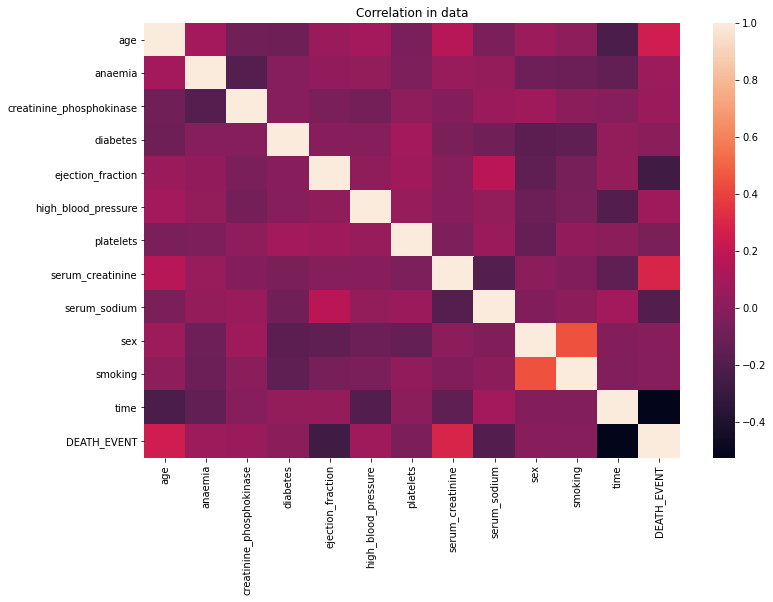

In [5]:
# Generate a heatmap to see how data correlates
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr())
plt.title('Correlation in data')
plt.show()

For DEATH_EVENT, age and serum_creatinine stand out.
Let's further explore this by using sklearn's ExtraTreesClassifier

Each Decision Tree in the Extra Trees Forest is constructed from the original training sample. Then, at each test node, Each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some mathematical criteria (typically the Gini Index). This random sample of features leads to the creation of multiple de-correlated decision trees.

Further explanation: https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/

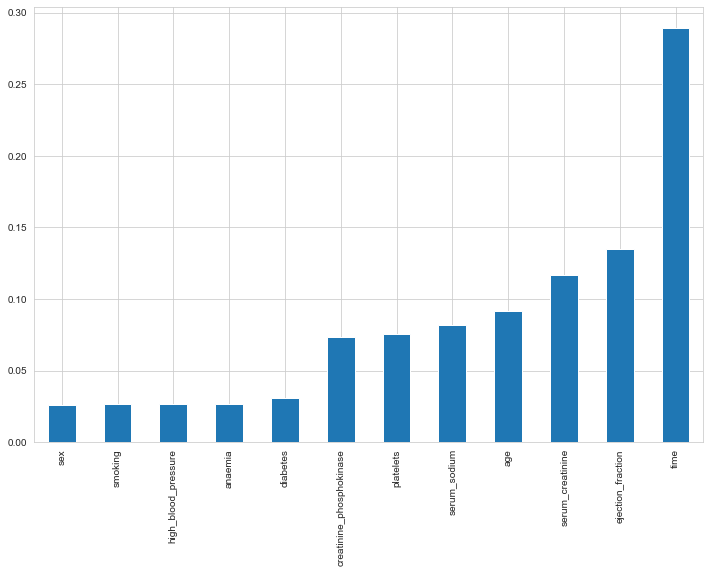

In [6]:
# Explore the nummer of unique values
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

x = df.iloc[:, :-1]
y = df.iloc[:,-1]

exttree = ExtraTreesClassifier()
exttree.fit(x,y)
feat_importances = pd.Series(exttree.feature_importances_, index=x.columns)
feat_importances.nsmallest(12).plot(kind='bar')
plt.show()

Features for further analysis: age, time, ejection_fraction and serum_creatinine

### Checking boundaries and outliers of key features

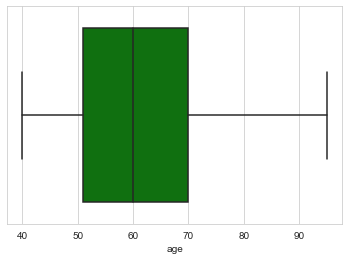

In [7]:
sns.boxplot(x = df.age, color = 'green')
plt.show()

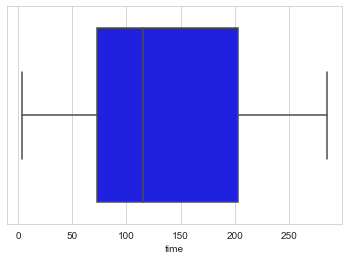

In [8]:
sns.boxplot(x = df.time, color = 'blue')
plt.show()

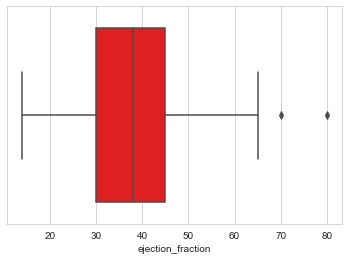

In [9]:
sns.boxplot(x = df.ejection_fraction, color = 'red')
plt.show()

Looking at outliers, from 70

In [10]:
df[df['ejection_fraction']>=70]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
64,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
217,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,196,1


There are only 2 records which i will remove and replot

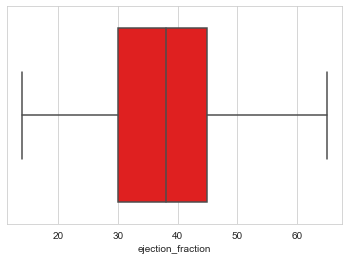

In [11]:
df = df[df['ejection_fraction']<70]
sns.boxplot(x = df.ejection_fraction, color = 'red')
plt.show()

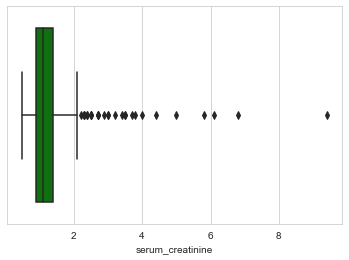

In [12]:
sns.boxplot(x = df.serum_creatinine, color = 'green')
plt.show()

In [13]:
df[df['serum_creatinine']>=2].describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,66.352941,0.411765,480.441176,0.382353,34.382353,0.294118,258922.295000,3.338235,133.911765,0.647059,0.264706,93.441176,0.617647
std,12.162741,0.499554,824.039834,0.493270,10.885116,0.462497,98436.533488,1.620515,5.905147,0.485071,0.447811,71.382109,0.493270
min,42.000000,0.000000,23.000000,0.000000,17.000000,0.000000,51000.000000,2.000000,116.000000,0.000000,0.000000,8.000000,0.000000
25%,60.000000,0.000000,69.750000,0.000000,25.000000,0.000000,215250.000000,2.300000,131.250000,0.000000,0.000000,32.750000,0.000000
50%,62.000000,0.000000,164.000000,0.000000,35.000000,0.000000,241500.000000,2.700000,134.000000,1.000000,0.000000,82.000000,1.000000
75%,74.250000,1.000000,574.750000,1.000000,40.000000,1.000000,321500.000000,3.650000,136.000000,1.000000,0.750000,130.000000,1.000000
max,95.000000,1.000000,3964.000000,1.000000,62.000000,1.000000,507000.000000,9.400000,146.000000,1.000000,1.000000,250.000000,1.000000


What the boxplot shows as being outliers is 11,4% of the dataset, so do not interprete the values as outliers. But will instead look at the correlation between the selected features.

### Correlation plot of key features 

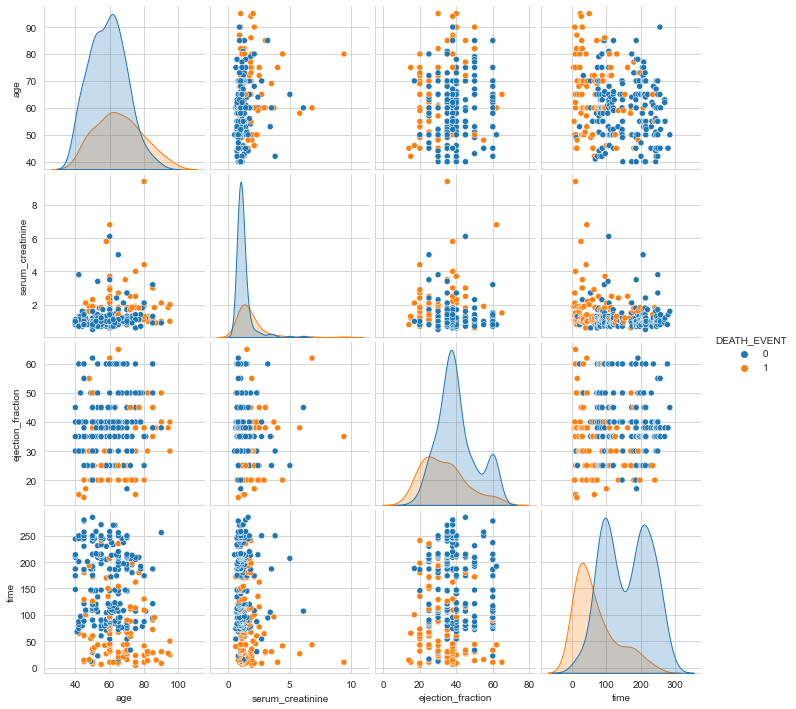

In [14]:
sns.pairplot(data=df[['age','serum_creatinine','ejection_fraction','time','DEATH_EVENT']], hue='DEATH_EVENT')

The plots show that time is a factor, as shorter follow up time lead to a higher death rate. But it doesn't influence the importance of serum creatinine and ejection fraction, so we can narrow it down to these to parameters. To rule out factors as diabetes, smoking and high blood pressure, lets look at them specifically. 

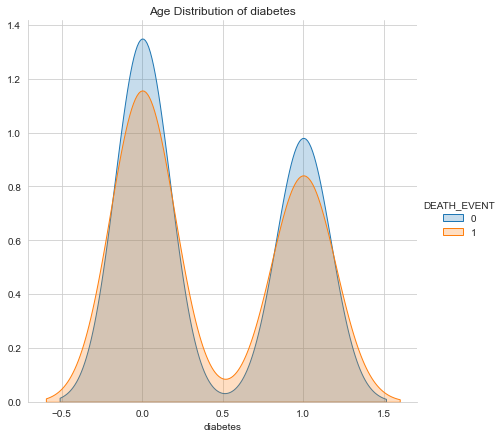

In [15]:
sns.FacetGrid(df, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "diabetes",shade=True).add_legend()
plt.title('Age Distribution of diabetes')
plt.show()


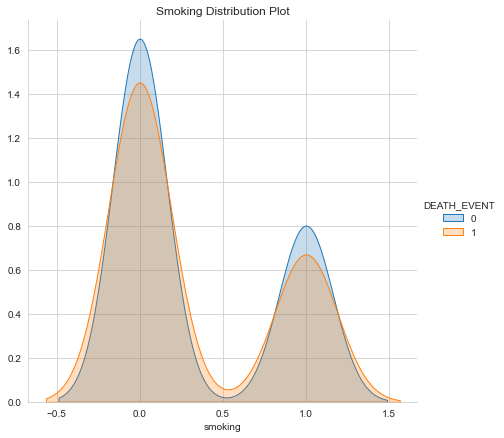

In [16]:
sns.FacetGrid(df, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "smoking",shade=True).add_legend()
plt.title('Smoking Distribution Plot')
plt.show()

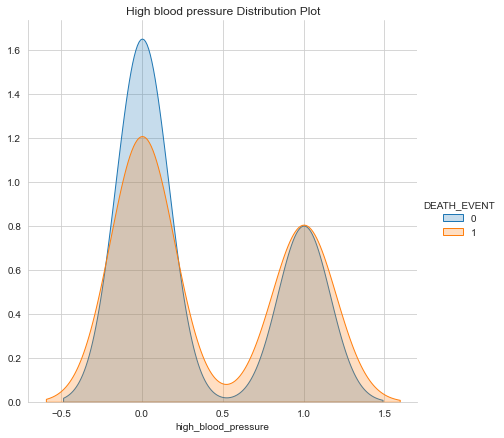

In [17]:
sns.FacetGrid(df, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "high_blood_pressure",shade=True).add_legend()
plt.title('High blood pressure Distribution Plot')
plt.show()

As seen above, diabetes, smoking and high blood pressure does not play a significant role in this dataset.

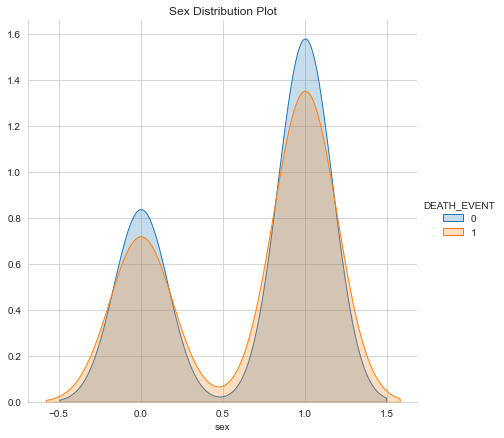

In [18]:
sns.FacetGrid(df, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "sex",shade=True).add_legend()
plt.title('Sex Distribution Plot')
plt.show()


## Standardizing data and preparing data for modelling

In [19]:
feat_std = ['age','creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time']
scaler = StandardScaler()
df[feat_std] = scaler.fit_transform(df[feat_std])

In [20]:
# Splitting dataset into features in X and DEATH_EVENT in y
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT'].copy()

In [21]:
# Set train and test dataset with 25% for testing
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

### Decision Tree

In [22]:
model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
model.fit(train_X,train_y)
pred=model.predict(test_X)
acc_dt = accuracy_score(pred,test_y)
f1_dt = f1_score(test_y, pred, average='weighted')
print('Accuracy of Decision Tree is', acc_dt)
print('F1 score of Decision Tree is', f1_dt)

Accuracy of Decision Tree is 0.92
F1 score of Decision Tree is 0.9176719576719576


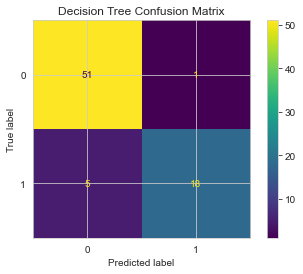

In [23]:
plot_confusion_matrix(model, test_X, test_y)
plt.title('Decision Tree Confusion Matrix')
plt.show()

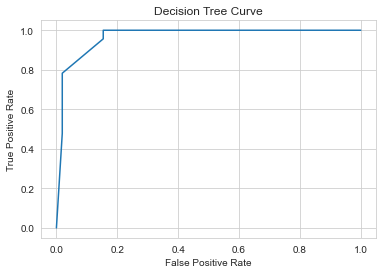

In [24]:
y_pred_prob = model.predict_proba(test_X)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
plt.plot(fpr, tpr, label='DT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Curve')
plt.show()

### KNN - K nearest neighbor
As we do not know which k to select for the model, the following code takes the range from 1 to 10 and selects the k with the highest accuracy.

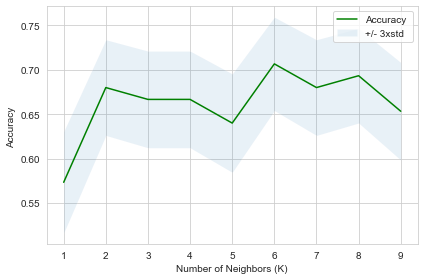

The best accuracy was with 0.7066666666666667 with k= 6
F1-score:  0.6599011299435028


In [25]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_X,train_y)
    yhat=neigh.predict(test_X)
    mean_acc[n-1] = accuracy_score(test_y, yhat)
    std_acc[n-1]=np.std(yhat==test_y)/np.sqrt(yhat.shape[0])
    
# Plot
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Result
best_k = mean_acc.argmax()+1
print( "The best accuracy was with", mean_acc.max(), "with k=", best_k)
neigh = KNeighborsClassifier(n_neighbors = best_k).fit(train_X,train_y)
yhat=neigh.predict(test_X)
f1_score_knn = f1_score(test_y, yhat, average='weighted')
print("F1-score: ", f1_score_knn)

### Support vector machine

In [26]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(train_X, train_y)
yhat = model_svm.predict(test_X)
svm_acc = accuracy_score(test_y, yhat)
print("SVM's Accuracy: ", svm_acc)
f1_score_svm = f1_score(test_y, yhat, average='weighted')
print("SVM F1-score: ", f1_score_svm)

SVM's Accuracy:  0.6933333333333334
SVM F1-score:  0.6091177356218006


### Linear regression
SVM showed poor performance, so linear regression is expected to do poorly. It is a simple process and then this model can savely be dismissed from this solution.

In [27]:
model_lr = LogisticRegression(C=0.0001, solver='liblinear')
model_lr.fit(train_X,train_y)
lr_prod=model_lr.predict(test_X)
lr_acc = accuracy_score(test_y, lr_prod)
print("Logistic regression's Accuracy: ", lr_acc)
f1_score_lr = f1_score(test_y, lr_prod, average='weighted')
print("Logistic regression F1-score: ", f1_score_lr)

Logistic regression's Accuracy:  0.6933333333333334
Logistic regression F1-score:  0.5677690288713911


### Random forest classifier
As decision tree shows good results, but with fear of overfitting, this model is user to check if we could still get good results and take some of the overfitting concers.

The accuracy of the Random Forest Classifier is 0.92
Random Forest Classifier F1-score:  0.5677690288713911


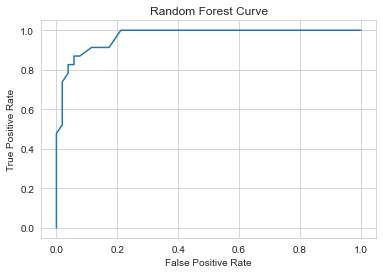

In [28]:
model = RandomForestClassifier(random_state=0)
model.fit(train_X,train_y)
prediction=model.predict(test_X)
f1_score_rf = f1_score(test_y, lr_prod, average='weighted')
print('The accuracy of the Random Forest Classifier is', accuracy_score(prediction,test_y))
print("Random Forest Classifier F1-score: ", f1_score_rf)

y_pred_prob = model.predict_proba(test_X)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
# plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Curve')
plt.show()